In [14]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [4]:
assert tf.__version__ > '2.0'

In [36]:
# Download dataset Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 1s 0us/step


In [15]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [40]:
coding_size = 10


inputs = keras.layers.Input(shape=[28, 28])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(units=150, activation='elu')(x)
x = keras.layers.Dense(units=100, activation='elu')(x)
coding_mean = keras.layers.Dense(units=coding_size)(x)
coding_logvar = keras.layers.Dense(units=coding_size)(x)
codings = Sampling()([coding_mean, coding_logvar])

var_encoder = keras.models.Model(inputs=[inputs], outputs=[coding_mean,
                                                         coding_logvar,
                                                         codings])
dec_inputs = keras.layers.Input(shape=(coding_size))
x = keras.layers.Dense(units=100, activation='elu')(dec_inputs)
x = keras.layers.Dense(units=150, activation='elu')(x)
x = keras.layers.Dense(units=28*28, activation='sigmoid')(x)

outputs = keras.layers.Reshape([28, 28])(x)
var_decoder = keras.models.Model(inputs=[dec_inputs], outputs=[outputs])




In [41]:
_, _, codings = var_encoder(inputs)
reconstructions = var_decoder(codings)

variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])


latent_loss = -0.5 * K.sum(
    1 + coding_logvar - K.exp(coding_logvar) - K.square(coding_mean),
    axis=-1)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


In [42]:
variational_ae.add_loss(K.mean(latent_loss)/784)
variational_ae.compile(loss='binary_crossentropy',
                       optimizer='rmsprop',
                       metrics=[rounded_accuracy] )

In [43]:
model_history = variational_ae.fit(X_train, 
                                   X_train, 
                                   epochs=25, 
                                   batch_size=128, 
                                   validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3800 - rounded_accuracy: 0.8642 - val_loss: 0.3442 - val_rounded_accuracy: 0.8983
Epoch 2/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3365 - rounded_accuracy: 0.9004 - val_loss: 0.3348 - val_rounded_accuracy: 0.9038
Epoch 3/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.3276 - rounded_accuracy: 0.9078 - val_loss: 0.3265 - val_rounded_accuracy: 0.9107
Epoch 4/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3233 - rounded_accuracy: 0.9114 - val_loss: 0.3245 - val_rounded_accuracy: 0.9136
Epoch 5/25
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3208 - rounded_accuracy: 0.9137 - val_loss: 0.3227 - val_rounded_accuracy: 0.9105
Epoch 6/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3189 - rounded_accuracy: 0.9153 - val

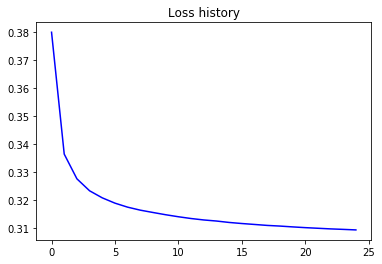

In [58]:
loss_list = model_history.history['loss']
plt.plot(loss_list, color='blue')
plt.title('Loss history')
plt.show()

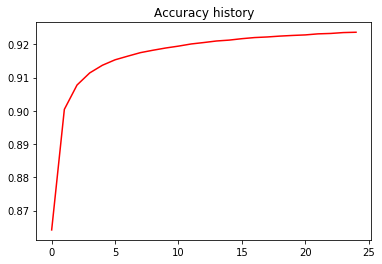

In [57]:
acc_list = model_history.history['rounded_accuracy']
plt.plot(acc_list, color='red')
plt.title('Accuracy history')
plt.show()

In [61]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

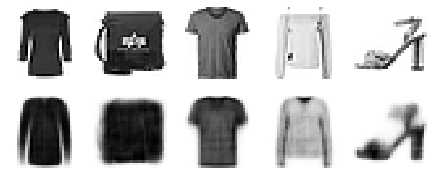

In [62]:
show_reconstructions(variational_ae)